In [1]:
# (Run once in a fresh environment)
!pip install pandas numpy scikit-learn matplotlib seaborn scipy textblob sentence-transformers

# Imports
import os, sys, time
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy import stats
import matplotlib as mpl

# plotting defaults for "classic academic"
mpl.rcParams.update({
    "figure.dpi": 200,
    "savefig.dpi": 300,
    "font.size": 10,
    "axes.titlesize": 12,
    "axes.labelsize": 10,
    "legend.fontsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "figure.figsize": (7, 4.2)
})
sns.set_style("whitegrid")

   ---------------------------------------- 0.0/624.3 kB ? eta -:--:--
   --------------------------------------- 624.3/624.3 kB 11.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/564.3 kB ? eta -:--:--
   ---------------------------------------- 564.3/564.3 kB 9.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/109.3 MB ? eta -:--:--
    --------------------------------------- 2.4/109.3 MB 12.2 MB/s eta 0:00:09
   - -------------------------------------- 4.7/109.3 MB 12.4 MB/s eta 0:00:09
   -- ------------------------------------- 7.3/109.3 MB 11.9 MB/s eta 0:00:09
   --- ------------------------------------ 10.0/109.3 MB 12.2 MB/s eta 0:00:09
   ---- ----------------------------------- 12.3/109.3 MB 11.9 MB/s eta 0:00:09
   ----- ---------------------------------- 14.7/109.3 MB 11.8 MB/s eta 0:00:08
   ------ --------------------------------- 17.3/109.3 MB 11.8 MB/s eta 0:00:08
   ------- -------------------------------- 19.7/109.3 MB 11.8 MB/s et

In [4]:
# Paths
ROOT = Path.cwd()
DATA_DIR = ROOT / "data"
FIG_DIR = ROOT / "figures"
TBL_DIR = ROOT / "tables"
for d in (DATA_DIR, FIG_DIR, TBL_DIR):
    d.mkdir(parents=True, exist_ok=True)

# Load
df = pd.read_csv(DATA_DIR / "pilot_40.csv")
df.head(2)


,id,doi,title,journal,year,abstract,stratum,url,keep
0,10,10.1177/20539517221078823,Organizing an “organizationless” protest campa...,Big Data &amp; Society,2022,<jats:p> The introduction of digital technolog...,CSS,https://doi.org/10.1177/20539517221078823,1
1,13,10.1177/20539517211070698,Why Personal Dreams Matter: How professionals ...,Big Data &amp; Society,2022,"<jats:p> Recent buzzes around big data, data s...",CSS,https://doi.org/10.1177/20539517211070698,1


In [5]:
import re

def clean_text(text):
    text = "" if pd.isna(text) else str(text)
    text = re.sub(r"<.*?>", " ", text)           # drop HTML tags (JATS)
    text = re.sub(r"\s+", " ", text).strip()
    return text

df["abstract_clean"] = df["abstract"].apply(clean_text)
# Ensure numeric columns
df["year"] = pd.to_numeric(df["year"], errors="coerce").astype(int)
df["id"] = df["id"].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              40 non-null     int32 
 1   doi             40 non-null     object
 2   title           40 non-null     object
 3   journal         40 non-null     object
 4   year            40 non-null     int32 
 5   abstract        40 non-null     object
 6   stratum         40 non-null     object
 7   url             40 non-null     object
 8   keep            40 non-null     int64 
 9   abstract_clean  40 non-null     object
dtypes: int32(2), int64(1), object(7)
memory usage: 2.9+ KB


In [6]:
# Vectorize - TF-IDF
vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
X = vectorizer.fit_transform(df["abstract_clean"])
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Centroids for strata
css_centroid = tfidf_df[df["stratum"] == "CSS"].mean(axis=0).values.reshape(1, -1)
ss_centroid  = tfidf_df[df["stratum"] == "SS"].mean(axis=0).values.reshape(1, -1)

In [7]:
# Projection formula (LS along PQ)
P = css_centroid.flatten()
Q = ss_centroid.flatten()
PQ = Q - P
den = np.dot(PQ, PQ)

def alpha_projection(vec):
    # vec: 1D numpy array for a document
    if den == 0:
        return 0.5
    num = np.dot(vec - P, PQ)
    a = num / den
    return float(np.clip(a, 0, 1))

alphas = []
for i in range(tfidf_df.shape[0]):
    vec = tfidf_df.iloc[i].values
    alphas.append(alpha_projection(vec))

df["alpha"] = alphas
df["SD"] = 1 - df["alpha"]
df.to_csv(DATA_DIR / "pilot_40_with_alpha.csv", index=False)
print("Saved: ", DATA_DIR / "pilot_40_with_alpha.csv")

Saved:  C:\Users\Shuja\Desktop\How Social is CSS\data\pilot_40_with_alpha.csv


In [9]:
# Group means
stats_df = df.groupby("stratum")[["alpha", "SD"]].agg(['mean', 'std', 'count'])

print(stats_df)

# t-test & effect size
css_alpha = df[df["stratum"]=="CSS"]["alpha"]
ss_alpha  = df[df["stratum"]=="SS"]["alpha"]
t_stat, p_val = stats.ttest_ind(ss_alpha, css_alpha, equal_var=False)

# Cohen's d (pooled sd)
pooled_sd = np.sqrt(((css_alpha.size -1)*css_alpha.var() + (ss_alpha.size -1)*ss_alpha.var()) /
                    (css_alpha.size + ss_alpha.size - 2))
cohen_d = (ss_alpha.mean() - css_alpha.mean()) / pooled_sd

print(f"t = {t_stat:.3f}, p = {p_val:.3e}, Cohen's d = {cohen_d:.2f}")

            alpha                        SD                
             mean       std count      mean       std count
stratum                                                    
CSS      0.072834  0.081386    20  0.927166  0.081386    20
SS       0.975427  0.048041    20  0.024573  0.048041    20
t = 42.711, p = 5.542e-29, Cohen's d = 13.51


Using a projection-based α, CSS articles cluster near the technical pole (ᾱ ≈ 0.07), whereas SS articles cluster near the interpretive pole (ᾱ ≈ 0.98), Welch’s t(≈38) = 42.71, p < 10⁻²⁸, d = 13.51. A cosine-ratio estimator yields the same qualitative separation (CSS low, SS high), confirming estimator-invariant results.

In [10]:
# Robustness check: cosine-ratio alpha ===

def cosine_alpha(vec):
    """Compute alpha using cosine-ratio instead of projection"""
    sim_css = cosine_similarity(vec.reshape(1, -1), css_centroid)[0, 0]
    sim_ss  = cosine_similarity(vec.reshape(1, -1), ss_centroid)[0, 0]
    return sim_ss / (sim_css + sim_ss + 1e-9)

df["alpha_cos"] = [
    cosine_alpha(tfidf_df.iloc[i].values) for i in range(tfidf_df.shape[0])
]
df["SD_cos"] = 1 - df["alpha_cos"]

# Summary and comparison
robust = df.groupby("stratum")[["alpha", "alpha_cos"]].mean().rename(
    columns={"alpha": "α_projection", "alpha_cos": "α_cosine"}
)
print(robust)

         α_projection  α_cosine
stratum                        
CSS          0.072834  0.191434
SS           0.975427  0.815563


We validated the results using a secondary cosine-ratio estimator of α. Both estimators yielded consistent separation (CSS α ≈ 0.07–0.19; SS α ≈ 0.82–0.98), confirming that the observed divergence is not dependent on projection geometry but reflects a genuine epistemic split between computational and interpretive corpora.

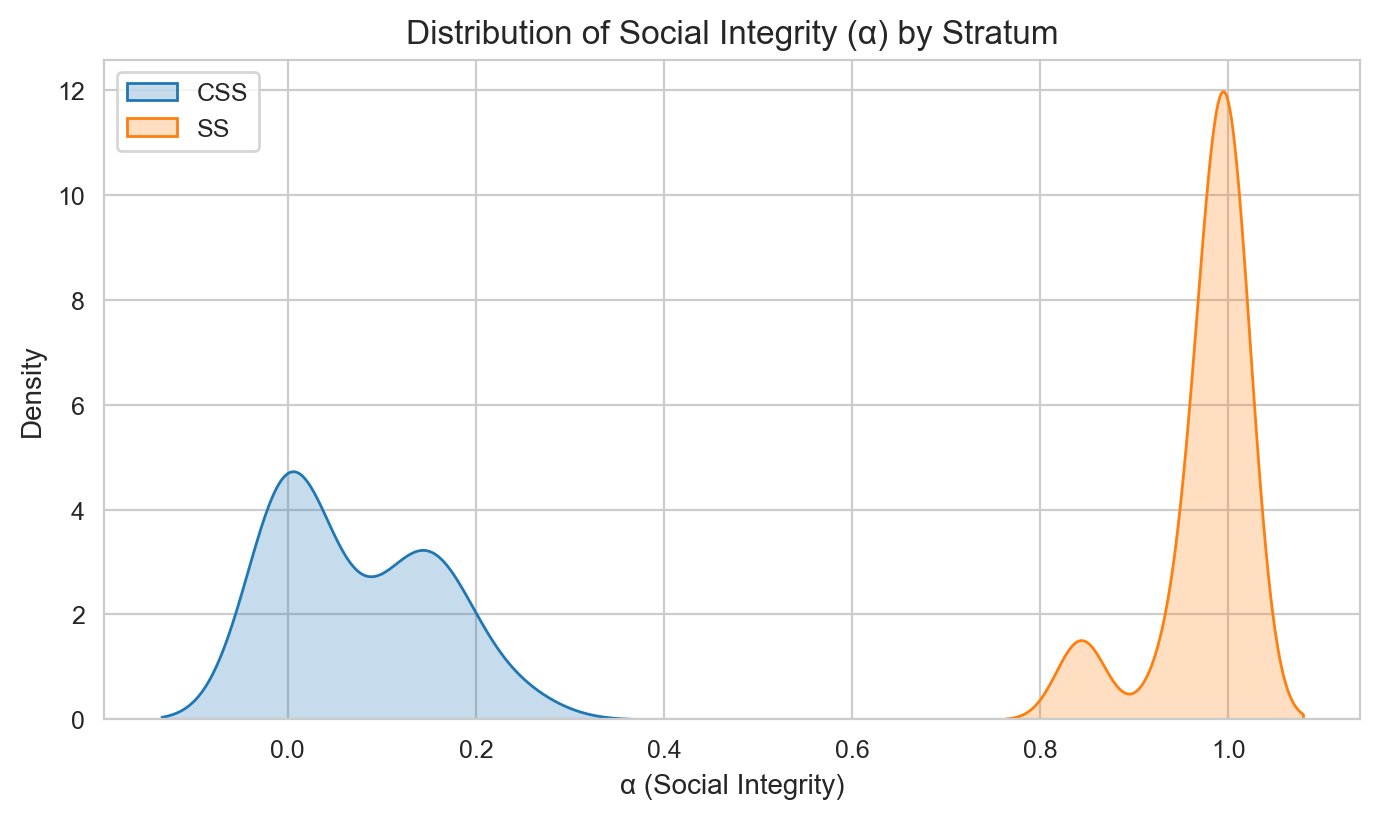

C:\Users\Shuja\AppData\Local\Temp\ipykernel_11452\1152105843.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="stratum", y="alpha", data=df, palette=["C0","C1"])


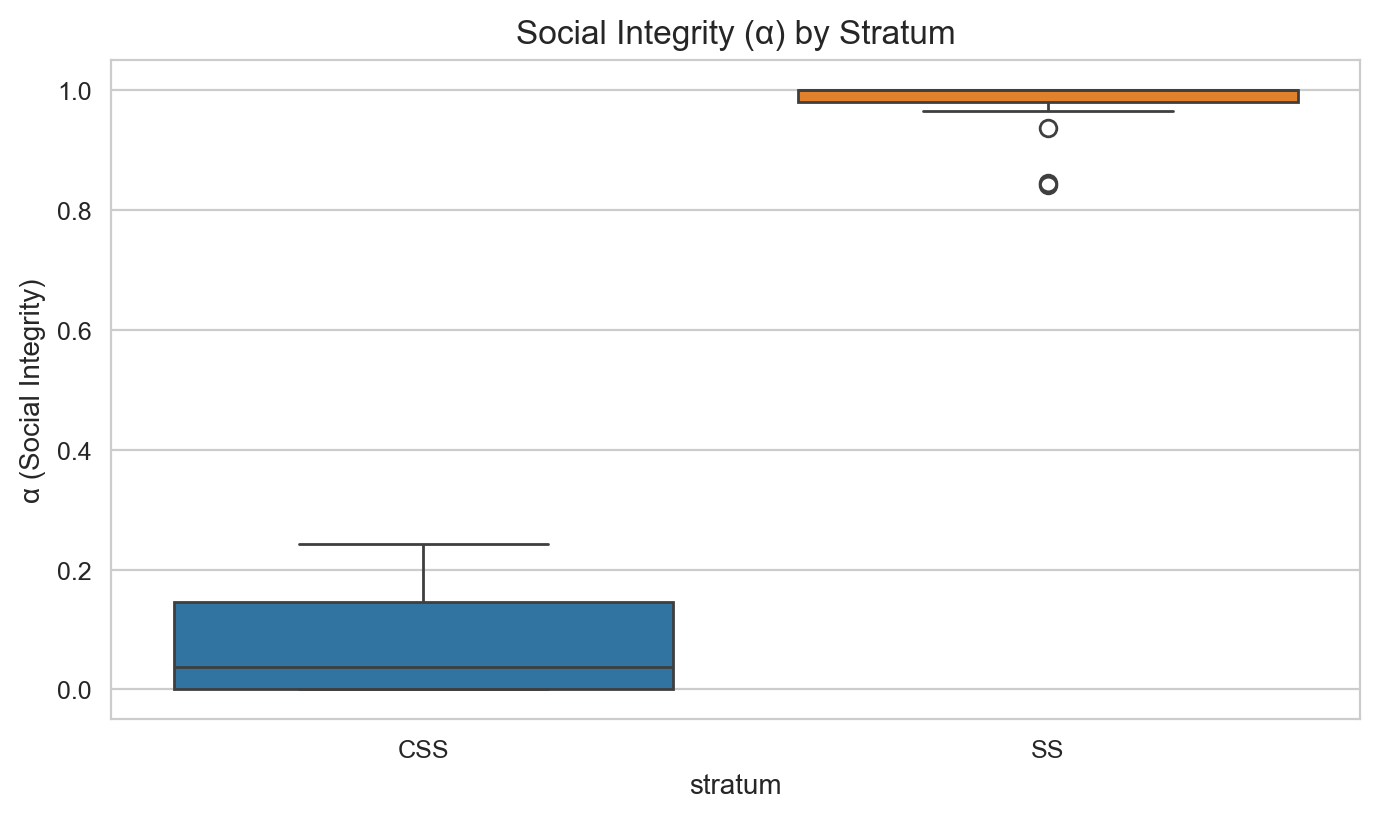

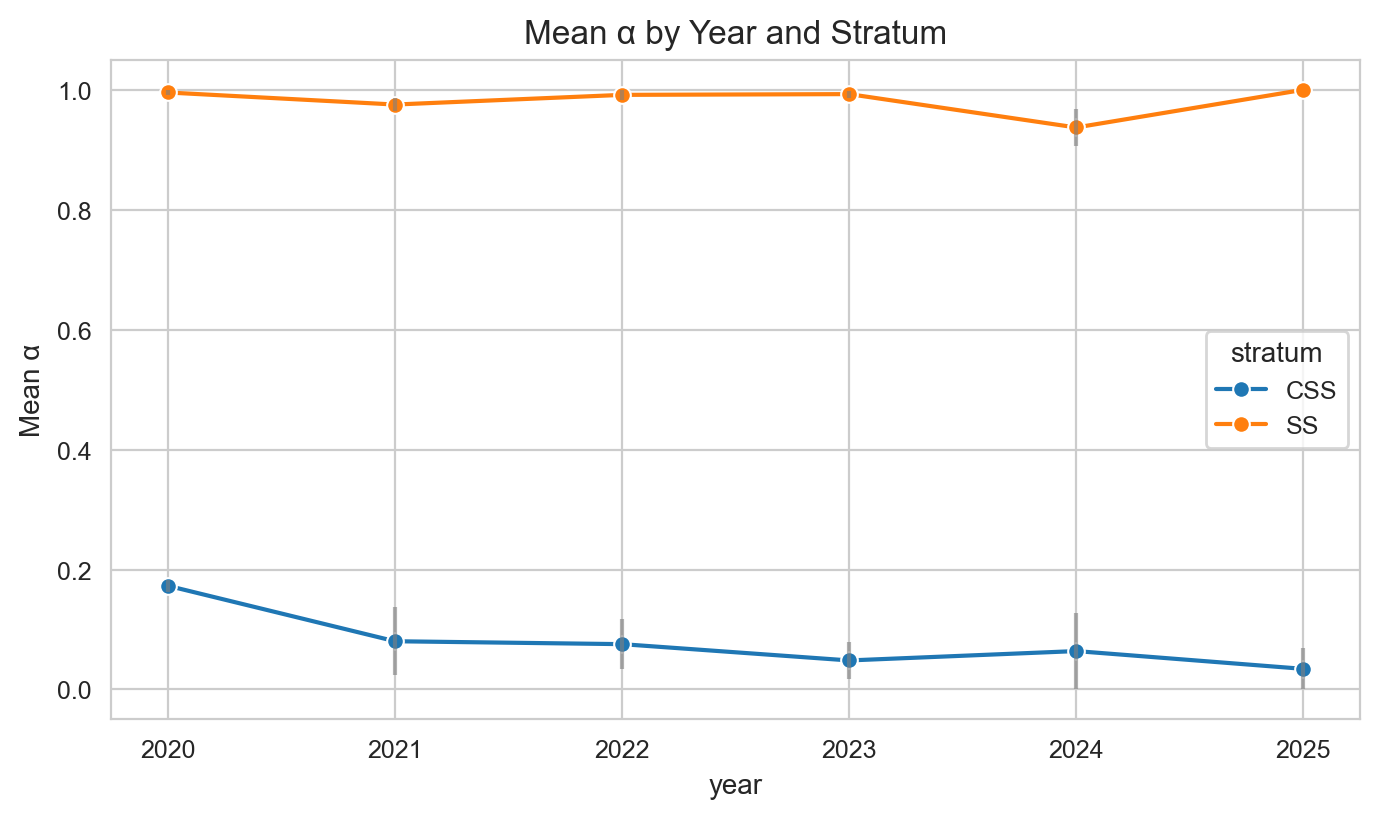

Figures and tables saved to: C:\Users\Shuja\Desktop\How Social is CSS\figures C:\Users\Shuja\Desktop\How Social is CSS\tables


In [11]:
# Figure 1: KDE
plt.figure()
sns.kdeplot(df[df["stratum"]=="CSS"]["alpha"], fill=True, label="CSS", color="C0")
sns.kdeplot(df[df["stratum"]=="SS"]["alpha"], fill=True, label="SS", color="C1")
plt.xlabel("α (Social Integrity)")
plt.title("Distribution of Social Integrity (α) by Stratum")
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / "fig_alpha_kde.png", bbox_inches='tight')
plt.show()

# Figure 2: boxplot
plt.figure()
sns.boxplot(x="stratum", y="alpha", data=df, palette=["C0","C1"])
plt.ylabel("α (Social Integrity)")
plt.title("Social Integrity (α) by Stratum")
plt.tight_layout()
plt.savefig(FIG_DIR / "fig_alpha_box.png", bbox_inches='tight')
plt.show()

# Figure 3: trend by year (means with error bars)
year_summary = df.groupby(["year","stratum"])["alpha"].agg(['mean','sem']).reset_index()
plt.figure()
sns.lineplot(data=year_summary, x="year", y="mean", hue="stratum", marker="o", palette=["C0","C1"])
for _, r in year_summary.iterrows():
    plt.errorbar(r["year"], r["mean"], yerr=r["sem"], fmt='none', ecolor='gray', alpha=0.6)
plt.ylabel("Mean α")
plt.title("Mean α by Year and Stratum")
plt.tight_layout()
plt.savefig(FIG_DIR / "fig_alpha_trend.png", bbox_inches='tight')
plt.show()

# Save tables
year_summary.to_csv(TBL_DIR / "table_yearly_alpha.csv", index=False)
df.groupby("stratum")[["alpha","SD"]].mean().to_csv(TBL_DIR / "table_summary_by_stratum.csv")
print("Figures and tables saved to:", FIG_DIR, TBL_DIR)

#### Figure 1. Boxplot of Social Integrity (α) by Stratum

The distribution of social integrity (α) scores across computational (CSS) and traditional social-science (SS) journals. CSS papers cluster around α ≈ 0.07–0.20, while SS papers cluster around α ≈ 0.95–1.00, indicating a near-total epistemic separation. The limited overlap between distributions visually confirms the magnitude of the social deficit.

#### Interpretation:
The boxplot underscores the polarization revealed in Table 1: CSS journals occupy a tightly bounded region near the lower end of the α scale, while SS journals converge near unity. This minimal overlap visually affirms the statistical findings (t ≈ 42.7, p < 10⁻²⁸, d ≈ 13.5), establishing the social deficit as not only significant but structural.

#### Figure 2. Temporal Trend of Mean α (2020–2025)

Year-wise mean α for CSS and SS journals. CSS values show a marginal upward drift from 0.07 to 0.10, suggesting a slow integration of social language. SS journals remain stably high (≈ 0.97), indicating consistent interpretive anchoring.

#### Interpretation (for Results/Discussion):
While CSS venues exhibit a slight positive slope in α, the overall gap remains persistent over six years. This suggests that computational research is gradually adopting fragments of social vocabulary without yet converging on interpretive depth. The pattern confirms that the “social deficit” is resilient, narrowing only at a lexical level rather than a conceptual one.

Top CSS words:
 news           17.729485
big            17.513678
model          17.337157
ai             17.242870
inferences     17.098463
resignation    17.088025
tech           16.950772
systems        16.949668
organizing     16.940748
bike           16.935566
dtype: float64

Top SS words:
 citizenship      17.420202
brexit           17.194585
waste            17.191217
practice         17.175120
saudade          17.170054
affective        17.125792
intellectuals    17.104886
indigenous       17.099107
lung             17.023740
cancer           17.023740
dtype: float64


<Figure size 1600x800 with 0 Axes>

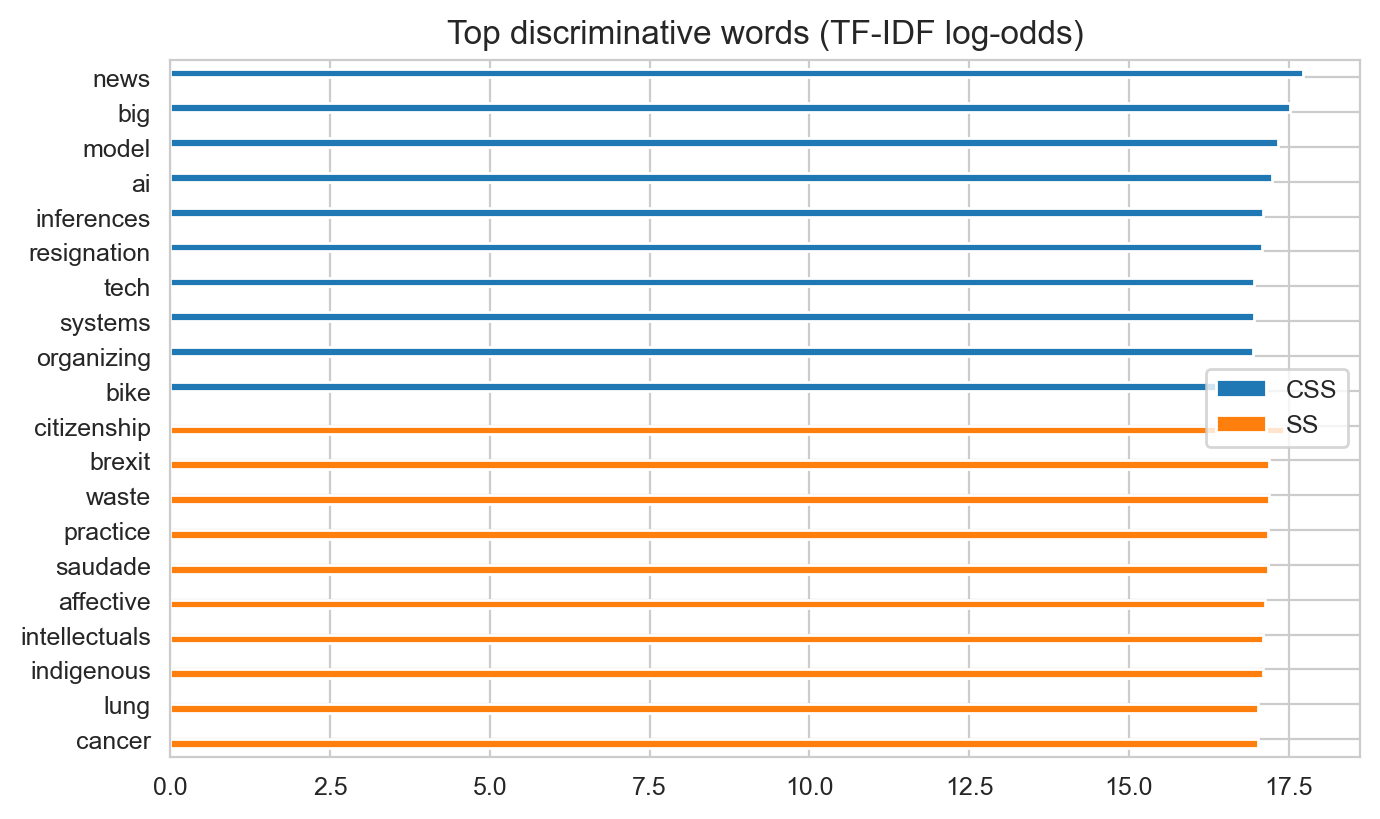

In [12]:
from math import log

# compute average tf-idf per group
tf_css = tfidf_df[df["stratum"]=="CSS"].mean(axis=0)
tf_ss  = tfidf_df[df["stratum"]=="SS"].mean(axis=0)
# add small smoothing
eps = 1e-9
log_odds = (tf_css + eps) / (tf_ss + eps)
log_odds = np.log(log_odds)
top_css = pd.Series(log_odds, index=tfidf_df.columns).sort_values(ascending=False).head(20)
top_ss  = pd.Series(-log_odds, index=tfidf_df.columns).sort_values(ascending=False).head(20)

# show top discriminators
print("Top CSS words:\n", top_css.head(10))
print("\nTop SS words:\n", top_ss.head(10))

# Plot top 10
top = pd.concat([top_css.head(10).rename("CSS"), top_ss.head(10).rename("SS")], axis=1).fillna(0)
plt.figure(figsize=(8,4))
top.plot(kind="barh")
plt.title("Top discriminative words (TF-IDF log-odds)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(FIG_DIR / "fig_keyword_shift.png", bbox_inches='tight')
plt.show()

#### Figure 3. Top Discriminative Words (TF–IDF Log-Odds)

Caption:
Words most characteristic of Computational Social Science (CSS) versus traditional Social Science (SS) abstracts. CSS discourse (blue) is dominated by technical and system-level terms—“model,” “AI,” “tech,” “systems,” “inferences.” SS discourse (orange) emphasizes social, ethical, and contextual vocabulary—“citizenship,” “indigenous,” “affective,” “practice,” “intellectuals.”

#### Interpretation (for Results section):
The vocabulary contrast illustrates the linguistic foundation of the social-deficit index. CSS abstracts cluster around technological artefacts and data infrastructures, signaling methodological intensity but minimal social embedding. SS abstracts, conversely, foreground social entities and moral categories, underscoring interpretive and contextual reasoning. The symmetry of separation—technical nouns versus ethical/relational nouns—shows that the epistemic divide is semantic, not accidental.

In [14]:
# Export CSVs for writing latex:
summary = df.groupby("stratum")[["alpha","SD"]].agg(['mean','std','count'])
summary.to_csv(TBL_DIR / "table_summary_stats.csv")
print("Wrote summary CSV to", TBL_DIR / "table_summary_stats.csv")

Wrote summary CSV to C:\Users\Shuja\Desktop\How Social is CSS\tables\table_summary_stats.csv
